## Import Libraries

In [1]:
%matplotlib inline

import os
import shutil
import random
import torch
import torchvision
import numpy as np

from PIL import Image
from matplotlib import pyplot as plt

torch.manual_seed(0)

print('Using PyTorch version', torch.__version__)

Using PyTorch version 1.10.2


## Preparing Training and Test Sets

In [2]:
VAL_SIZE = 0.2

class_names = ['normal', 'viral', 'covid']
root_dir = 'COVID-19_Radiography_Dataset'
source_dirs = ['Normal/images', 'Viral Pneumonia/images', 'COVID/images']

if os.path.isdir(os.path.join(root_dir, source_dirs[1])):
    os.mkdir(os.path.join(root_dir, 'train'))
    os.mkdir(os.path.join(root_dir, 'test'))

    for c in class_names:
        os.mkdir(os.path.join(root_dir, 'train', c))
        os.mkdir(os.path.join(root_dir, 'test', c))

    for i, d, in enumerate(source_dirs):
        os.rename(os.path.join(root_dir, d), os.path.join(root_dir, 'train', class_names[i]))

    for c in class_names:
        images = [x for x in os.listdir(os.path.join(root_dir, 'train', c)) if x.lower().endswith('png')]
        selected_images = random.sample(images, int(len(images) * VAL_SIZE))
        for image in selected_images:
            source_path = os.path.join(root_dir, 'train', c, image)
            target_path = os.path.join(root_dir, 'test', c, image)
            shutil.move(source_path, target_path)





## Creating Custom Dataset

In [3]:
class ChestXRayDataset(torch.utils.data.Dataset):
    def __init__(self, image_dirs, transform):
        def get_images(class_name, verbose=1):
            images = [x for x in os.listdir(image_dirs[class_name]) if x[-3:].lower().endswith('png')]
            if verbose == 1:
                print(f'Found {len(images)} {class_name} examples')
            return images
        
        self.images = {}
        self.class_names = ['normal', 'viral', 'covid']

        for class_name in self.class_names:
            self.images[class_name] = get_images(class_name)

        self.image_dirs = image_dirs
        self.transform = transform

    def __len__(self):
        return sum([len(self.images[class_name]) for class_name in self.class_names])

    def __getitem__(self, index):
        class_name = random.choice(self.class_names)
        index = index % len(self.images[class_name])
        image_name = self.images[class_name][index]
        image_path = os.path.join(self.image_dirs[class_name], image_name)
        image = Image.open(image_path).convert('RGB')
        return self.transform(image), self.class_names.index(class_name)


## Image transformation

In [4]:
train_transform = torchvision.transforms.Compose(transforms=[
    torchvision.transforms.Resize(size=(224,224)),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225])
])

In [5]:
test_transform = torchvision.transforms.Compose(transforms=[
    torchvision.transforms.Resize(size=(224,224)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225])
])

## Data Loader

In [6]:
train_dirs = {}
for class_name in class_names:
    train_dirs[class_name] = os.path.join(root_dir, 'train', class_name)


train_dataset = ChestXRayDataset(train_dirs, train_transform)

Found 8154 normal examples
Found 1076 viral examples
Found 2893 covid examples


In [7]:
test_dirs = {}
for class_name in class_names:
    test_dirs[class_name] = os.path.join(root_dir, 'test', class_name)

test_dataset = ChestXRayDataset(test_dirs, test_transform)

Found 2038 normal examples
Found 269 viral examples
Found 723 covid examples


In [9]:
batch_size = 6

dataloader_train = torch.utils.data.DataLoader(train_dataset, 
                                        batch_size=batch_size,
                                        shuffle=True)

dataloader_test = torch.utils.data.DataLoader(test_dataset,
                                        batch_size=batch_size,
                                        shuffle=True)

print('Num. of training batches', len(dataloader_train))
print('Num. of test batches', len(dataloader_test))

Num. of training batches 2021
Num. of test batches 505


## Data Visualization

In [11]:
cllass_names = train_dataset.class_names

def show_images(images, labels, preds):
    plt.figure(figsize=(8,4))
    for i, image in enumerate(images):
        plt.subplot(1, 6, i + 1, xticks=[], yticks=[])
        image = image.numpy().transpose((1, 2, 0))
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = image * std + mean
        image = np.clip(image, 0., 1.)
        plt.imshow(image)

        col = 'green' if preds[i] == labels[i] else 'red'

        plt.xlabel(f'{class_names[int(labels[i].numpy())]}')
        plt.ylabel(f'{class_names[int(preds[i].numpy())]}', color=col)
    plt.tight_layout()
    plt.show()

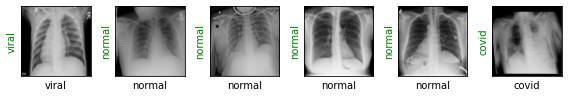

In [12]:
images, labels = next(iter(dataloader_train))
show_images(images, labels, labels)

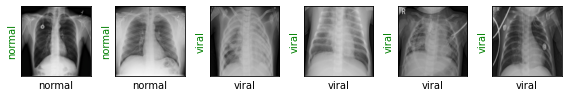

In [13]:
images, labels = next(iter(dataloader_test))
show_images(images, labels, labels)

## Create the Model